# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 7: Análisis de redes sociales

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 22 de septiembre de 2024


### 💻 Carga de la información

In [1]:
import os
import json
import re
import nltk
import pydot
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from IPython.display import Image, display
from networkx.drawing.nx_pydot import write_dot, read_dot

In [2]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

df_tweets = pd.DataFrame(tweets)
print(df_tweets)

                       id               id_str  \
0     1834281080029110288  1834281080029110288   
1     1834252464092069901  1834252464092069901   
2     1834280919336976681  1834280919336976681   
3     1834280512933732694  1834280512933732694   
4     1834279986254987428  1834279986254987428   
...                   ...                  ...   
5014  1832570119563743682  1832570119563743682   
5015  1832569640079270018  1832569640079270018   
5016  1832569563109896313  1832569563109896313   
5017  1832568528508968963  1832568528508968963   
5018  1832567980749660272  1832567980749660272   

                                                    url  \
0     https://x.com/La_ReVoluZzion/status/1834281080...   
1     https://x.com/XelaNewsGt/status/18342524640920...   
2     https://x.com/M24095273/status/183428091933697...   
3     https://x.com/carlosalbesc/status/183428051293...   
4     https://x.com/Brenda_AGN/status/18342799862549...   
...                                          

### 🧹 Limpieza y preprocesamiento de datos

Como parte inicial se decide eliminar columnas duplicadas de IDs. Además, se remueven columnas que cuentan en su mayoría con valores nulos ya que no aportan información de manera significativa respecto al total de datos. 

In [3]:
df_tweets.head(10)
df_tweets.columns

Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')

In [4]:
for i in ['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr']:
    if i in df_tweets.columns:
        df_tweets = df_tweets.drop(columns=['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr'])

In [5]:
df_tweets.head(10)
df_tweets[['_type']].nunique()

_type    1
dtype: int64

In [6]:
for i in ['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr', '_type']:
    if i in df_tweets.columns:
        df_tweets = df_tweets.drop(columns=['_type'])

In [7]:
df_tweets.head(10)
df_tweets[['card']]
df_tweets[['card']].count()

non_null_values = df_tweets['card'].dropna()
print(non_null_values)

11      {'title': '🔴 | El presidente @BArevalodeLeon p...
22      {'title': '🔴 | El presidente @BArevalodeLeon p...
33      {'title': '🔴 | El presidente @BArevalodeLeon p...
34      {'title': '🔴 | El presidente @BArevalodeLeon p...
136     {'title': 'Xela News (@xelanewsgt) • Instagram...
439     {'title': 'Fabiola Roudha interpreta el himno ...
483     {'title': 'Resumen de noticias – miércoles 11 ...
624     {'title': 'CC anula fallo que confirmó condena...
685     {'title': 'Ricardo Mendez Ruiz', 'description'...
749     {'title': 'MP busca retirar la inmunidad del p...
801     {'title': 'Arévalo comparte con pobladores de ...
882     {'title': 'MP busca retirar la inmunidad del p...
985     {'title': 'TikTok · Fernando Cajas', 'descript...
1012    {'title': 'Presidente resalta el valor de los ...
1134    {'title': 'Más de 9 mil familias con insegurid...
1245    {'title': 'El futuro del agua', 'description':...
1430    {'title': 'Presidente Arévalo resalta legado e...
1432    {'titl

In [8]:
if 'card' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['card'])

In [9]:
df_tweets.head(10)

id                       date  \
0  1834281080029110288  2024-09-12 17:21:03+00:00   
1  1834252464092069901  2024-09-12 15:27:20+00:00   
2  1834280919336976681  2024-09-12 17:20:25+00:00   
3  1834280512933732694  2024-09-12 17:18:48+00:00   
4  1834279986254987428  2024-09-12 17:16:42+00:00   
5  1834279973336875425  2024-09-12 17:16:39+00:00   
6  1834279773021110367  2024-09-12 17:15:51+00:00   
7  1834279757351137308  2024-09-12 17:15:48+00:00   
8  1834279356719661450  2024-09-12 17:14:12+00:00   
9  1834279190562308253  2024-09-12 17:13:32+00:00   

                                                user lang  \
0  {'id': 1435062946598694914, 'id_str': '1435062...   es   
1  {'id': 956650778634145792, 'id_str': '95665077...   es   
2  {'id': 1087057038755143680, 'id_str': '1087057...   es   
3  {'id': 2881001877, 'id_str': '2881001877', 'ur...   es   
4  {'id': 3013862206, 'id_str': '3013862206', 'ur...   es   
5  {'id': 1628956392487878657, 'id_str': '1628956...   es   
6  {'id': 1456725120735748100, 'id_str': '1456725...   es   
7  {'id': 1049536922299846656, 'id_str': '1049536...   es   
8  {'id': 145724847, 'id_str': '145724847', 'url'...   es   
9  {'id': 749889296, 'id_str': '749889296', 'url'...   es   

                                          rawContent  replyCount  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...           0   
1  #URGENTE Lo que los medios #faferos no informa...          12   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...           0   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...           0   
4  El presidente @BArevalodeLeon y la vicepreside...           0   
5  @BArevalodeLeon El muy hijo de puta inyectó co...           0   
6  @EmisorasUnidas @BArevalodeLeon Y que de bueno...           0   
7  @IvanDuque @BArevalodeLeon Productiva es que g...           0   
8  @KarinHerreraVP El presidente de la República,...           0   
9  @mys_servicios @BArevalodeLeon No tampoco, ese...           0   

   retweetCount  likeCount  quoteCount  bookmarkedCount  ...  retweetedTweet  \
0             0          0           0                0  ...            None   
1            80        142          15               10  ...            None   
2             0          0           0                0  ...            None   
3             0          0           0                0  ...            None   
4             0          0           0                0  ...            None   
5             0          0           0                0  ...            None   
6             0          0           0                0  ...            None   
7             0          0           0                0  ...            None   
8             0          0           0                0  ...            None   
9             0          0           0                0  ...            None   

                                         quotedTweet place coordinates  \
0  {'id': 1834252464092069901, 'id_str': '1834252...  None        None   
1                                               None  None        None   
2                                               None  None        None   
3                                               None  None        None   
4                                               None  None        None   
5                                               None  None        None   
6                                               None  None        None   
7                                               None  None        None   
8                                               None  None        None   
9                                               None  None        None   

  inReplyToTweetId                                      inReplyToUser  \
0              NaN                                               None   
1              NaN                                               None   
2     1.834197e+18  {'id': 77653794, 'id_str': '77653794', 'userna...   
3     1.834197e+18  {'id': 

In [10]:
df_tweets[['coordinates']].count()
if 'coordinates' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['coordinates'])

In [11]:
df_tweets.head(10)
df_tweets[['lang']].count()
df_tweets[['lang']].nunique()

lang    20
dtype: int64

In [12]:
df_tweets[['place']].count()

on_null_values = df_tweets['place'].dropna()
print(non_null_values)

df_tweets[['place']].count()
if 'place' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['place'])

11      {'title': '🔴 | El presidente @BArevalodeLeon p...
22      {'title': '🔴 | El presidente @BArevalodeLeon p...
33      {'title': '🔴 | El presidente @BArevalodeLeon p...
34      {'title': '🔴 | El presidente @BArevalodeLeon p...
136     {'title': 'Xela News (@xelanewsgt) • Instagram...
439     {'title': 'Fabiola Roudha interpreta el himno ...
483     {'title': 'Resumen de noticias – miércoles 11 ...
624     {'title': 'CC anula fallo que confirmó condena...
685     {'title': 'Ricardo Mendez Ruiz', 'description'...
749     {'title': 'MP busca retirar la inmunidad del p...
801     {'title': 'Arévalo comparte con pobladores de ...
882     {'title': 'MP busca retirar la inmunidad del p...
985     {'title': 'TikTok · Fernando Cajas', 'descript...
1012    {'title': 'Presidente resalta el valor de los ...
1134    {'title': 'Más de 9 mil familias con insegurid...
1245    {'title': 'El futuro del agua', 'description':...
1430    {'title': 'Presidente Arévalo resalta legado e...
1432    {'titl

In [13]:
df_tweets.head(10)
if 'source' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['source'])

In [14]:
df_tweets.head(10)

id                       date  \
0  1834281080029110288  2024-09-12 17:21:03+00:00   
1  1834252464092069901  2024-09-12 15:27:20+00:00   
2  1834280919336976681  2024-09-12 17:20:25+00:00   
3  1834280512933732694  2024-09-12 17:18:48+00:00   
4  1834279986254987428  2024-09-12 17:16:42+00:00   
5  1834279973336875425  2024-09-12 17:16:39+00:00   
6  1834279773021110367  2024-09-12 17:15:51+00:00   
7  1834279757351137308  2024-09-12 17:15:48+00:00   
8  1834279356719661450  2024-09-12 17:14:12+00:00   
9  1834279190562308253  2024-09-12 17:13:32+00:00   

                                                user lang  \
0  {'id': 1435062946598694914, 'id_str': '1435062...   es   
1  {'id': 956650778634145792, 'id_str': '95665077...   es   
2  {'id': 1087057038755143680, 'id_str': '1087057...   es   
3  {'id': 2881001877, 'id_str': '2881001877', 'ur...   es   
4  {'id': 3013862206, 'id_str': '3013862206', 'ur...   es   
5  {'id': 1628956392487878657, 'id_str': '1628956...   es   
6  {'id': 1456725120735748100, 'id_str': '1456725...   es   
7  {'id': 1049536922299846656, 'id_str': '1049536...   es   
8  {'id': 145724847, 'id_str': '145724847', 'url'...   es   
9  {'id': 749889296, 'id_str': '749889296', 'url'...   es   

                                          rawContent  replyCount  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...           0   
1  #URGENTE Lo que los medios #faferos no informa...          12   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...           0   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...           0   
4  El presidente @BArevalodeLeon y la vicepreside...           0   
5  @BArevalodeLeon El muy hijo de puta inyectó co...           0   
6  @EmisorasUnidas @BArevalodeLeon Y que de bueno...           0   
7  @IvanDuque @BArevalodeLeon Productiva es que g...           0   
8  @KarinHerreraVP El presidente de la República,...           0   
9  @mys_servicios @BArevalodeLeon No tampoco, ese...           0   

   retweetCount  likeCount  quoteCount  bookmarkedCount  ...  \
0             0          0           0                0  ...   
1            80        142          15               10  ...   
2             0          0           0                0  ...   
3             0          0           0                0  ...   
4             0          0           0                0  ...   
5             0          0           0                0  ...   
6             0          0           0                0  ...   
7             0          0           0                0  ...   
8             0          0           0                0  ...   
9             0          0           0                0  ...   

                                      mentionedUsers links viewCount  \
0  [{'id': 23664866, 'id_str': '23664866', 'usern...    []       NaN   
1                                                 []    []    5200.0   
2  [{'id': 77653794, 'id_str': '77653794', 'usern...    []       NaN   
3  [{'id': 77653794, 'id_str': '77653794', 'usern...    []       NaN   
4  [{'id': 945378369818058752, 'id_str': '9453783...    []       7.0   
5  [{'id': 945378369818058752, 'id_str': '9453783...    []       3.0   
6  [{'id': 40256008, 'id_str': '40256008', 'usern...    []       3.0   
7  [{'id': 77653794, 'id_str': '77653794', 'usern...    []       2.0   
8  [{'id': 407880186, 'id_str': '407880186', 'use...    []      26.0   
9  [{'id': 1101674869148798976, 'id_str': '110167...    []       2.0   

  retweetedTweet                                        quotedTweet  \
0           None  {'id': 1834252464092069901, 'id_str': '1834252...   
1           None                                               None   
2           None                                               None   
3           None                                               None   
4           None                                               None   
5           None                                               None   
6           None    

In [15]:
non_empty_count = df_tweets['cashtags'].apply(lambda x: len(x) > 0).sum()
print(f'Número de listas con al menos un valor: {non_empty_count}')

Número de listas con al menos un valor: 2


In [16]:
if 'cashtags' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['cashtags'])

In [17]:
print(f'Numero de retweets: {df_tweets["retweetedTweet"].sum()}')

Numero de retweets: 0


In [18]:
df_tweets[['retweetedTweet']].count()
if 'retweetedTweet' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['retweetedTweet'])

In [19]:
non_empty_count = df_tweets['links'].apply(lambda x: len(x) > 0).sum()
print(f'Número de listas con al menos un valor: {non_empty_count}')
if 'links' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['links'])

Número de listas con al menos un valor: 120


Luego, centrandonos en la información del propio texto del tweet, se deciden realizar ciertas operaciones de limpieza que ayuden en el análisis de la información que este contiene. Las operaciones de limpieza que se realizaron sobre rawContent son:
- Convertir el texto a minúsculas (para asegurar la normalización de los hashtags y las menciones)
- Remover URLs
- Eliminar carácteres especiales.
- Reemplazar saltos de línea por espacios.
- Eliminar stopwords. 

In [20]:
# Crear una copia del DataFrame para trabajar sobre ella
df_tweets_cleaned = df_tweets.copy()

# 1. Convertir el texto a minúsculas
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].str.lower()


# 2. Quitar URLs
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# 3. Eliminar caracteres especiales, preservando @ y #
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'[^a-zA-Z0-9áéíóúñ@#\s]', '', x))

# 4. Reemplazar saltos de línea por espacios
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' '))

# 5. Eliminar stopwords
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))
def remove_stopwords(text):
    words = text.split()  
    filtered_words = [word for word in words if word not in spanish_stopwords] 
    return ' '.join(filtered_words)

df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(remove_stopwords)

print(df_tweets_cleaned[['rawContent']].head())

                                          rawContent
0  confirmado compañeres impuesto @usembassyguate...
1  #urgente medios #faferos informaron ayer acerc...
2  @ivanduque @barevalodeleon usaste pegasus espi...
3  @ivanduque @barevalodeleon entienden bien cuad...
4  presidente @barevalodeleon vicepresidenta @kar...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Como las menciones fueron convertidas a minúsculas los usernames correspondientes también fueron convertidos a su versión minúscula para seguir la misma estructura. 

In [21]:
def process_user(user, property_name):
    if isinstance(user, dict) and property_name in user:
        user[property_name] = user[property_name].lower()
    return user

In [22]:
def process_user2(user, property_name):
    if user:
        if property_name in user['user']:
            user['user'][property_name] = user['user'][property_name].lower()
    return user

In [23]:
def process_user3(user, property_name):
    if user:
        for i in user:
            if isinstance(i, dict) and property_name in i:
                i[property_name] = i[property_name].lower()
    return user

In [24]:
df_tweets_cleaned['user'] = df_tweets_cleaned['user'].apply(lambda x: process_user(x, 'username'))
df_tweets_cleaned['inReplyToUser'] = df_tweets_cleaned['inReplyToUser'].apply(lambda x: process_user(x, 'username'))
df_tweets_cleaned['quotedTweet'] = df_tweets_cleaned['quotedTweet'].apply(lambda x: process_user2(x, 'username'))
df_tweets_cleaned['mentionedUsers'] = df_tweets_cleaned['mentionedUsers'].apply(lambda x: process_user3(x, 'username'))

In [25]:
def convert_hashtags_to_lowercase(hashtags):
    return [hashtag.lower() for hashtag in hashtags]

In [26]:
df_tweets_cleaned['hashtags'] = df_tweets_cleaned['hashtags'].apply(convert_hashtags_to_lowercase)

Además, en función del contenido existente en rawContent, se eliminan tweets que estén duplicados en el dataset. 

In [27]:
duplicated_count = df_tweets['rawContent'].duplicated().sum()
print(f'Número de tweets duplicados: {duplicated_count}')
df_tweets_cleaned = df_tweets_cleaned.drop_duplicates(subset=['rawContent'])

Número de tweets duplicados: 86


In [28]:
duplicated_count = df_tweets_cleaned['rawContent'].duplicated().sum()
print(f'Número de tweets duplicados: {duplicated_count}')

Número de tweets duplicados: 0


### 📚 Análisis exploratorio

Observando cómo se encuentra formada la información del usuario, menciones, retweets, respuestas entre otros. 

In [29]:
dfUser = df_tweets_cleaned[1:2]['user']
for i in dfUser:
    print(i)

{'id': 956650778634145792, 'id_str': '956650778634145792', 'url': 'https://x.com/XelaNewsGt', 'username': 'xelanewsgt', 'displayname': 'XelaNews', 'rawDescription': 'Noticias sin injerencias.', 'created': '2018-01-25 22:11:34+00:00', 'followersCount': 3462, 'friendsCount': 359, 'statusesCount': 2915, 'favouritesCount': 5717, 'listedCount': 3, 'mediaCount': 1132, 'location': 'Guatemala', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1795602273034199040/B_YZsc0K_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/956650778634145792/1704817554', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [], '_type': 'snscrape.modules.twitter.User'}


In [30]:
dfInReplyToUser = df_tweets_cleaned[3:4]['inReplyToUser']
for i in dfInReplyToUser:
    print(i)

{'id': 77653794, 'id_str': '77653794', 'username': 'ivanduque', 'displayname': 'Iván Duque 🇨🇴', '_type': 'snscrape.modules.twitter.UserRef'}


In [31]:
dfMentionedUsers = df_tweets_cleaned[0:1]['mentionedUsers']
for i in dfMentionedUsers:
    for j in i:
        print(j)

{'id': 23664866, 'id_str': '23664866', 'username': 'usembassyguate', 'displayname': 'US Embassy Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 1001171061831020545, 'id_str': '1001171061831020545', 'username': '48cantonestoto', 'displayname': '48 Cantones Oficial', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 262691982, 'id_str': '262691982', 'username': 'usaidguate', 'displayname': 'USAID Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 1362391326, 'id_str': '1362391326', 'username': 'ueguatemala', 'displayname': 'Unión Europea en Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 945378369818058752, 'id_str': '945378369818058752', 'username': 'barevalodeleon', 'displayname': 'Bernardo Arévalo', '_type': 'snscrape.modules.twitter.UserRef'}


In [32]:
dfQuotedTweet = df_tweets_cleaned[0:1]['quotedTweet']
for i in dfQuotedTweet:
    print(i)
    

{'id': 1834252464092069901, 'id_str': '1834252464092069901', 'url': 'https://x.com/XelaNewsGt/status/1834252464092069901', 'date': '2024-09-12 15:27:20+00:00', 'user': {'id': 956650778634145792, 'id_str': '956650778634145792', 'url': 'https://x.com/XelaNewsGt', 'username': 'xelanewsgt', 'displayname': 'XelaNews', 'rawDescription': 'Noticias sin injerencias.', 'created': '2018-01-25 22:11:34+00:00', 'followersCount': 3462, 'friendsCount': 359, 'statusesCount': 2915, 'favouritesCount': 5717, 'listedCount': 3, 'mediaCount': 1132, 'location': 'Guatemala', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1795602273034199040/B_YZsc0K_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/956650778634145792/1704817554', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [], '_type': 'snscrape.modules.twitter.User'}, 'lang': 'es', 'rawContent': '#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la

Después de la limpieza y filtrado de usuarios se observa que se cuenta con 4713 entradas en total.

In [33]:
df_tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4713 entries, 0 to 5018
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4713 non-null   int64  
 1   date              4713 non-null   object 
 2   user              4713 non-null   object 
 3   lang              4713 non-null   object 
 4   rawContent        4713 non-null   object 
 5   replyCount        4713 non-null   int64  
 6   retweetCount      4713 non-null   int64  
 7   likeCount         4713 non-null   int64  
 8   quoteCount        4713 non-null   int64  
 9   bookmarkedCount   4713 non-null   int64  
 10  conversationId    4713 non-null   int64  
 11  hashtags          4713 non-null   object 
 12  mentionedUsers    4713 non-null   object 
 13  viewCount         4635 non-null   float64
 14  quotedTweet       274 non-null    object 
 15  inReplyToTweetId  4072 non-null   float64
 16  inReplyToUser     4160 non-null   object 
 17  

In [34]:
df_tweets_cleaned.describe()

id   replyCount  retweetCount     likeCount   quoteCount  \
count  4.713000e+03  4713.000000   4713.000000   4713.000000  4713.000000   
mean   1.832852e+18     6.377891     17.978358     91.542754     1.500530   
std    2.224593e+16   111.473081    253.094931   1785.949018    25.767564   
min    8.094212e+17     0.000000      0.000000      0.000000     0.000000   
25%    1.833205e+18     0.000000      0.000000      0.000000     0.000000   
50%    1.833599e+18     0.000000      0.000000      0.000000     0.000000   
75%    1.833911e+18     0.000000      0.000000      2.000000     0.000000   
max    1.834281e+18  4783.000000   8307.000000  67416.000000  1336.000000   

       bookmarkedCount  conversationId     viewCount  inReplyToTweetId  
count      4713.000000    4.713000e+03  4.635000e+03      4.072000e+03  
mean          4.066412    1.832311e+18  5.906320e+03      1.832954e+18  
std         105.225633    2.406518e+16  1.526856e+05      9.936211e+15  
min           0.000000    8.094212e+17  1.000000e+00      1.257873e+18  
25%           0.000000    1.832935e+18  8.000000e+00      1.832965e+18  
50%           0.000000    1.833493e+18  2.400000e+01      1.833493e+18  
75%           0.000000    1.833674e+18  8.100000e+01      1.833672e+18  
max        5277.000000    1.834281e+18  8.495723e+06      1.834279e+18

Resulta interesante que del total de tweets, prácticamente la mitad son usuarios únicos por lo que se podría indicar que en promedio hay 2 tweets de cada usuario.

In [35]:
df_tweets_cleaned['user']
usersList = []
for i in df_tweets_cleaned['user']:
    usersList.append(i['username'])

print(f'Número de usuarios únicos: {len(set(usersList))}')

Número de usuarios únicos: 2541


La información obtenida del conteo de palabras más frecuentes obviando la de Guatemala, indica que el conjunto se centra en las decisiones del gobierno. En este caso la mayor frecuencia se centra en temas urgentes, el Ministerio Finanzas, el Diario de Centro América y principalemente en el presupuesto para el 2025.

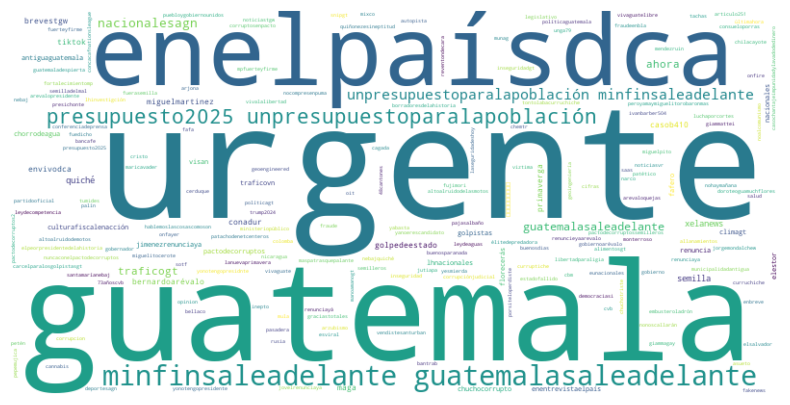

In [36]:
dfHashtags = df_tweets_cleaned[df_tweets_cleaned['hashtags'].apply(lambda x: len(x) > 0)]
hashtags = [hashtag for sublist in dfHashtags['hashtags'] for hashtag in sublist]
text = ' '.join(hashtags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Observando la frecuencia de palabras en los tweets (tomando en cuenta todo el conjunto de palabras) se observa que todas hablan del propio presidente Bernardo Arévalo, así como todo lo relacionado al Gobierno de Guatemala.

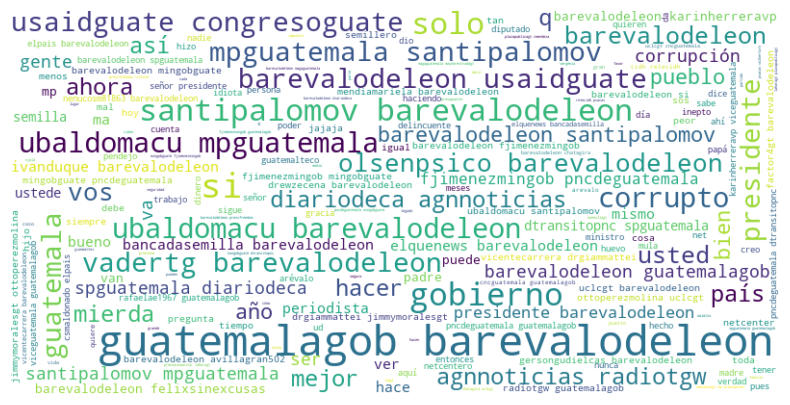

In [37]:
textTweets = ' '.join(df_tweets_cleaned['rawContent'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textTweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

De esta información, se plantean 3 temas principales a identificar. 

- ¿Se puede medir la aceptación del presidente?
- ¿Qué opinión (en términos positivos y/o negativos) tienen los guatemaltecos sobre el presupuesto 2025?
- ¿Existen estructuras de usuarios encargadas de mejorar o manipular la imagen del presidente?

### 👥 Análisis de la topología de la red.

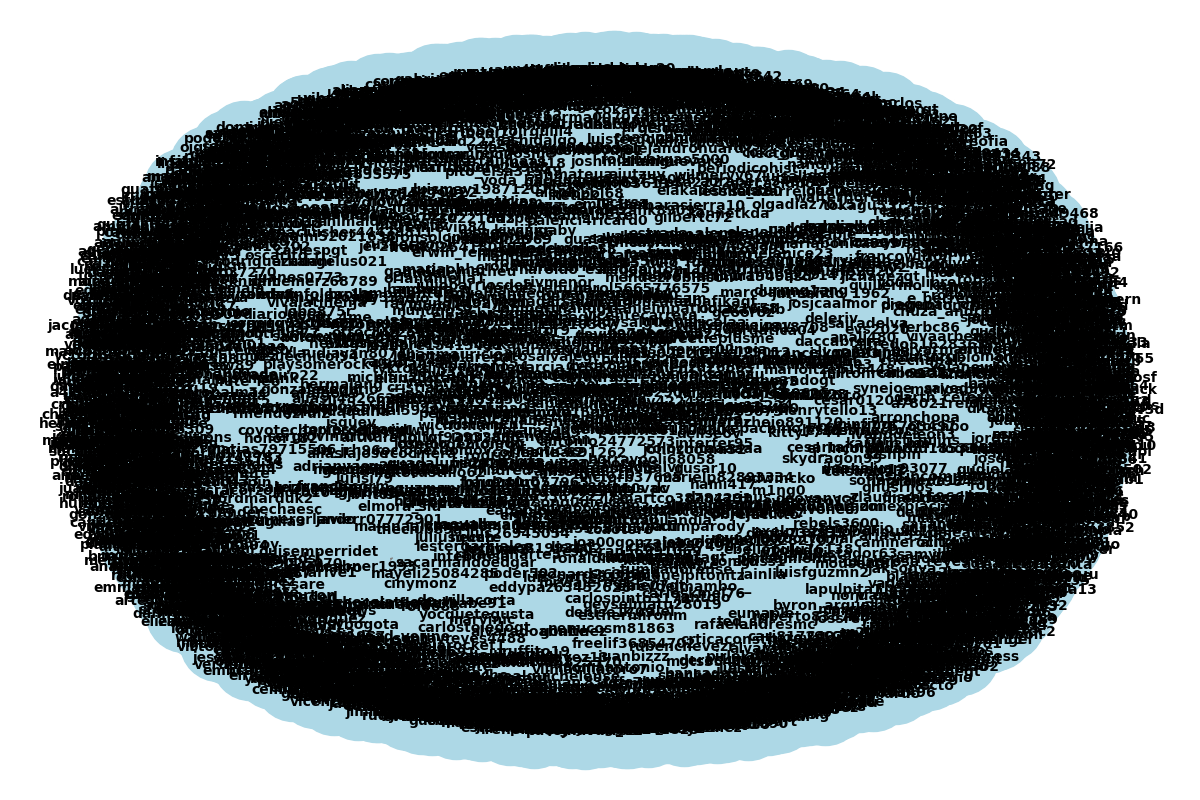

In [38]:

png_file = "MencionesV1.png"
dot_file = "MencionesV1.dot"

if not (os.path.exists(png_file) and os.path.exists(dot_file)):
    interactions = []
    for index, row in df_tweets_cleaned.iterrows():
        author = row['user']  
        author = author['username']
        mentioned_users = row['mentionedUsers'] 
        
        if isinstance(mentioned_users, list):
            for user in mentioned_users:
                mention = user.get('username', '').lower()
                if mention: 
                    interactions.append((author, mention))

    df_interactions = pd.DataFrame(interactions, columns=['source', 'target'])

    G = nx.from_pandas_edgelist(df_interactions, source='source', target='target', create_using=nx.DiGraph())

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold', arrows=True)
    plt.title("Grafo de menciones a usuarios en Twitter")
    plt.savefig("MencionesV1.png")
    write_dot(G, 'MencionesV1.dot')
else:
        # Mostrar el archivo PNG en pantalla
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")


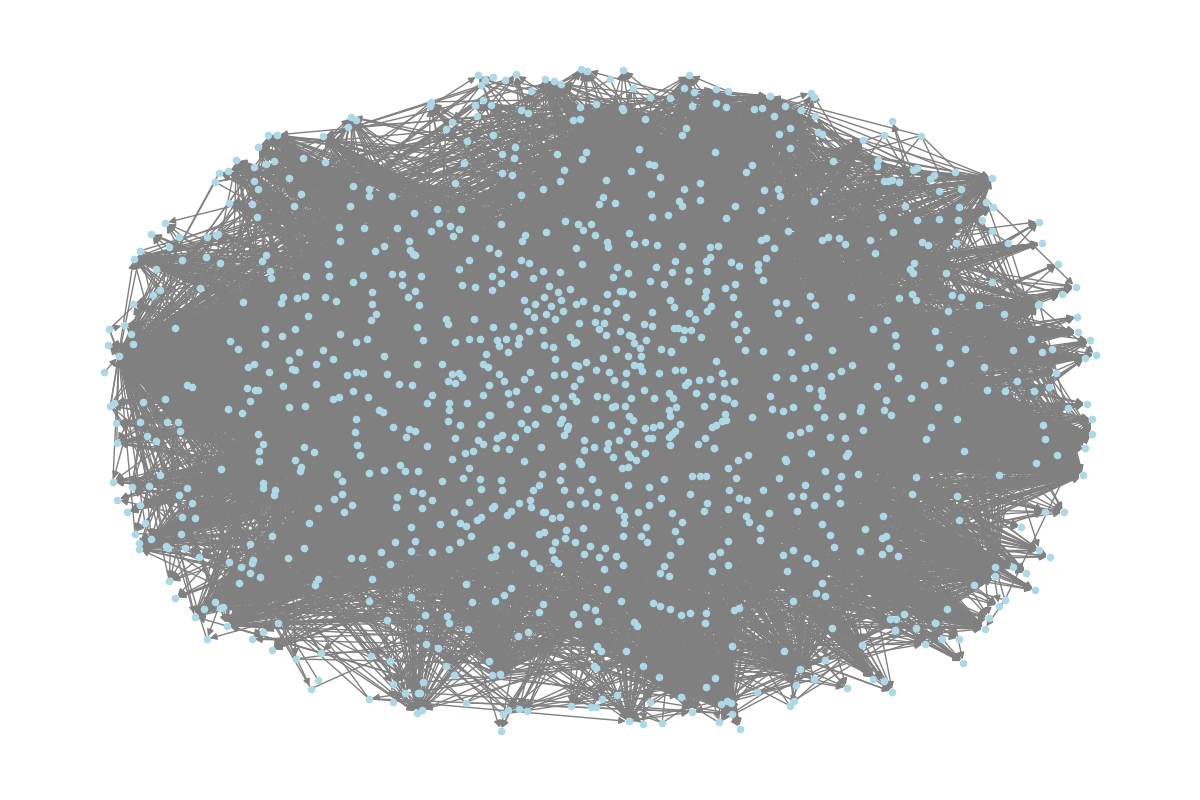

In [39]:
png_file = "MencionesV2.png"
dot_file = "MencionesV2.dot"

if not (os.path.exists(png_file) and os.path.exists(dot_file)):
    interactions = []
    for index, row in df_tweets_cleaned.iterrows():
        author = row['user']  
        author = author['username']
        mentioned_users = row['mentionedUsers'] 
        
        if isinstance(mentioned_users, list):
            for user in mentioned_users:
                mention = user.get('username', '').lower()
                if mention: 
                    interactions.append((author, mention))

    df_interactions = pd.DataFrame(interactions, columns=['source', 'target'])

    G = nx.from_pandas_edgelist(df_interactions, source='source', target='target', create_using=nx.DiGraph())

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50) 
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=20, font_size=12, font_weight='bold', arrows=True)
    plt.title("Grafo de menciones a usuarios en Twitter")
    plt.savefig(png_file)
    write_dot(G, dot_file)
else:
        # Mostrar el archivo PNG en pantalla
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")

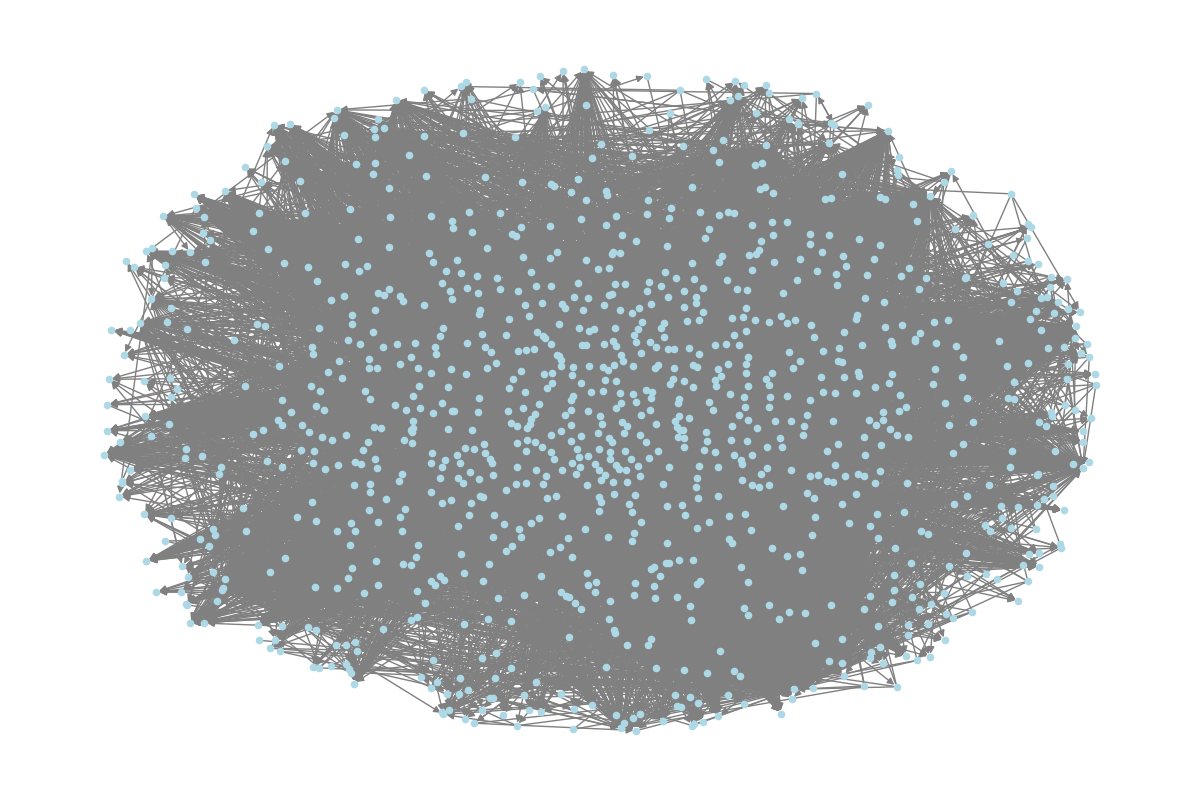

In [40]:

def load_graph_from_dot(dot_file):
    G = read_dot(dot_file)
    return G

def create_subgraph_by_degree(G, min_degree=1):
    nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
    subgraph = G.subgraph(nodes_to_keep).copy()
    return subgraph

if not os.path.exists('MencionesV3.png'):
    G = load_graph_from_dot('MencionesV2.dot')
    min_degree = 5 
    G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=0.5, iterations=50)
    nx.draw(G_sub, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=20, font_size=10, font_weight='bold', arrows=True)
    plt.title(f"Grafo de menciones (Nodos con grado >= {min_degree})")
    plt.savefig("MencionesV3.png")
else:
    if os.path.exists('MencionesV3.png'):
        img = Image(filename='MencionesV3.png')
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {'MencionesV3.png'}")    


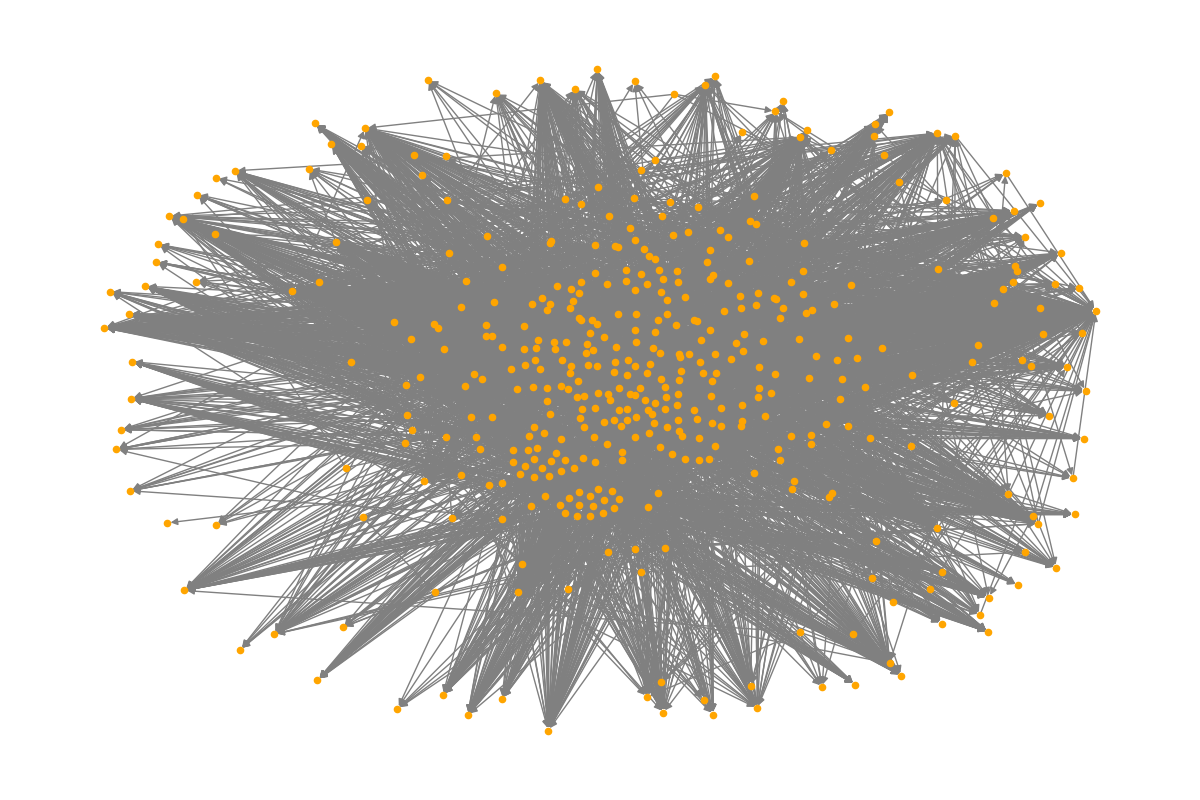

In [41]:
png_file = "MencionesV4.png"
if not os.path.exists(png_file):
    G = load_graph_from_dot('MencionesV2.dot')
    min_degree = 10
    G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=0.5, iterations=50)
    nx.draw(G_sub, pos, with_labels=False, node_color='orange', edge_color='gray', node_size=20, font_size=10, font_weight='bold', arrows=True)
    plt.title(f"Grafo de menciones (Nodos con grado >= {min_degree})")
    plt.savefig("MencionesV4.png")
else:
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")    

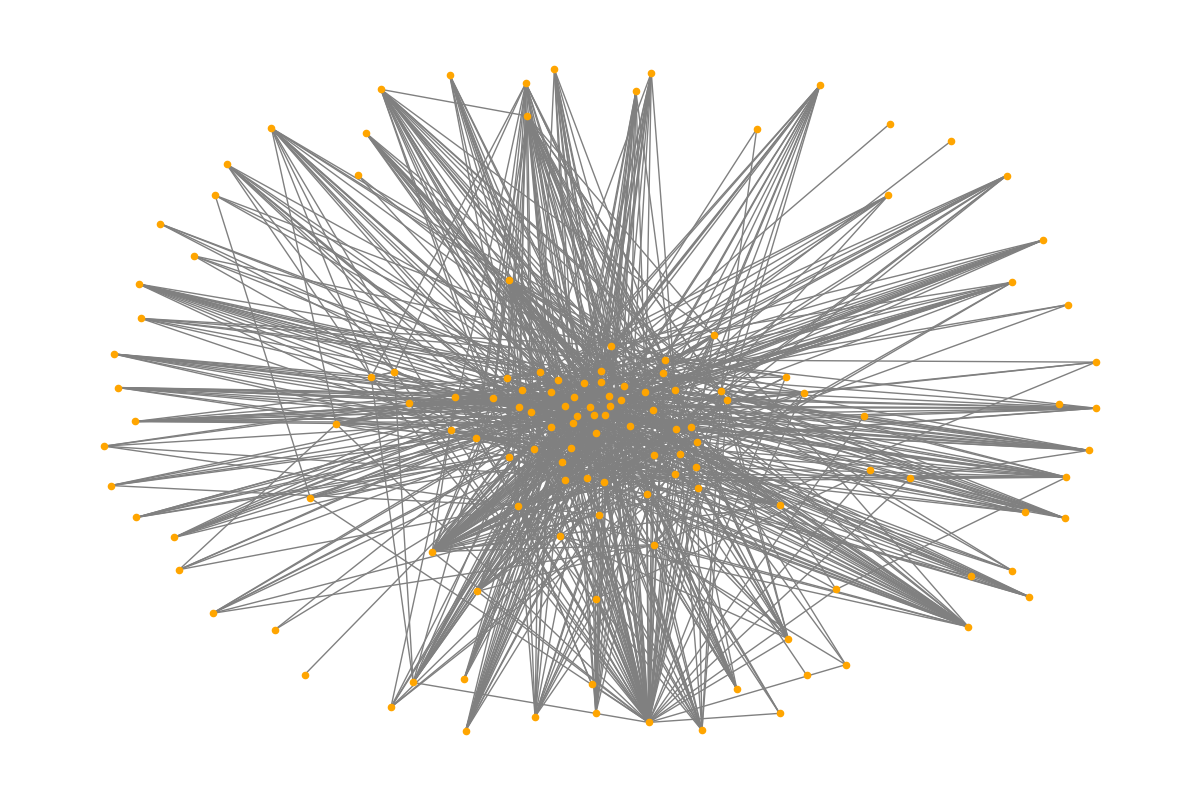

In [42]:
png_file = "MencionesV5.png"
if not os.path.exists(png_file):
    G = load_graph_from_dot('MencionesV2.dot')
    min_degree = 20
    G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=0.5, iterations=50)
    nx.draw(G_sub, pos, with_labels=False, node_color='orange', edge_color='gray', node_size=20, font_size=10, font_weight='bold', arrows=False)
    plt.title(f"Grafo de menciones (Nodos con grado >= {min_degree})")
    plt.savefig(png_file)
else:
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")    

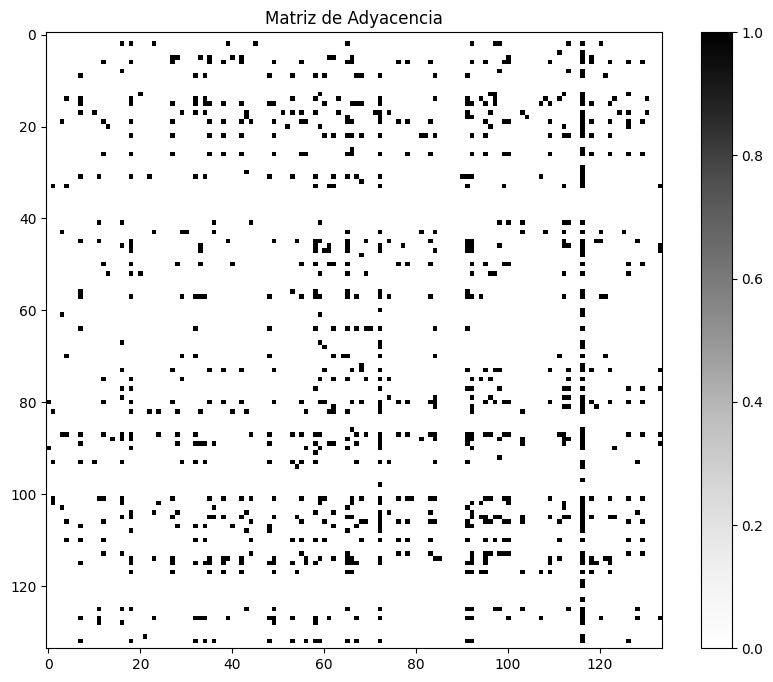

In [43]:
G = load_graph_from_dot('MencionesV2.dot')
min_degree = 20
G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
adj_matrix = nx.to_pandas_adjacency(G_sub)
plt.figure(figsize=(10, 8))
plt.imshow(adj_matrix, cmap='Greys', interpolation='none')
plt.title("Matriz de Adyacencia")
plt.colorbar()
plt.show()

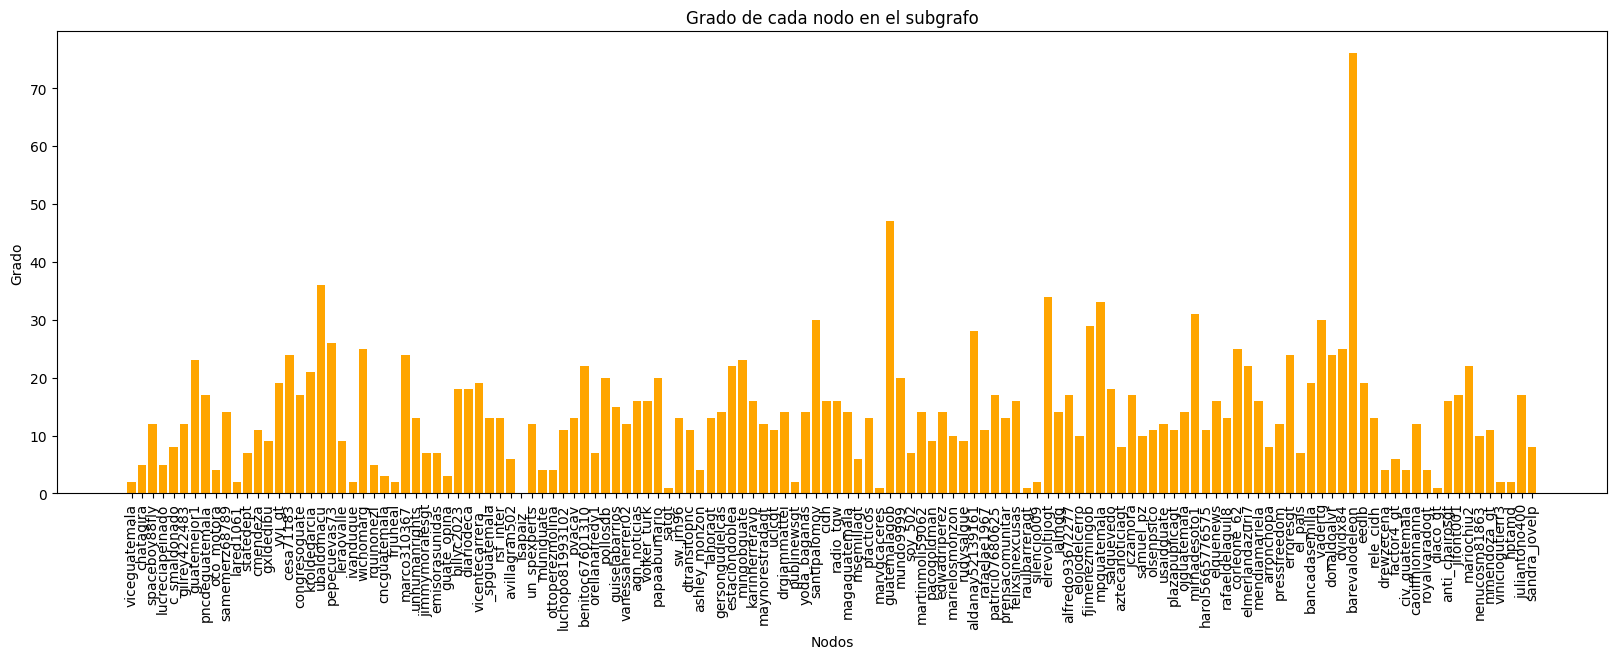

In [44]:
# Obtener los grados de los nodos
degrees = dict(G_sub.degree())
nodes = list(degrees.keys())
degree_values = list(degrees.values())

# Crear el gráfico de grados
plt.figure(figsize=(20, 6))
plt.bar(nodes, degree_values, color='orange')
plt.xlabel('Nodos')
plt.ylabel('Grado')
plt.title('Grado de cada nodo en el subgrafo')
plt.xticks(rotation=90)  # Rotar los nombres de los nodos si es necesario
plt.show()

In [45]:
density = nx.density(G_sub)
print(f'Densidad de la red: {density:.4f}')

# Calcular el diámetro de la red para un grafo dirigido
if nx.is_strongly_connected(G_sub):
    # Encuentra el diámetro para un grafo dirigido fuertemente conexo
    lengths = dict(nx.all_pairs_shortest_path_length(G_sub))
    max_length = max(max(lengths[node].values()) for node in lengths)
    print(f'Diámetro de la red: {max_length}')
    # En grafos dirigidos, se calcula el coeficiente de agrupamiento dirigido
    average_clustering = nx.average_clustering(G_sub, weight=None)
    print(f'Coeficiente de agrupamiento promedio: {average_clustering:.4f}')
    node_clustering = nx.clustering(G_sub, weight=None)
    print('Coeficiente de agrupamiento de cada nodo:')
    for node, clustering in node_clustering.items():
        print(f'Nodo {node}: {clustering:.4f}')
else:
    print('La red no está fuertemente conectada, el diámetro y el coeficiente de agrupamiento no están definidos.')

Densidad de la red: 0.0528
La red no está fuertemente conectada, el diámetro y el coeficiente de agrupamiento no están definidos.


### Identificación de análisis de comunidades

In [46]:
import community.community_louvain as community_louvain

# Convertir a grafo no dirigido para Louvain
G_undirected = G_sub.to_undirected()

# Aplicar el algoritmo de Louvain
partition = community_louvain.best_partition(G_undirected)

# Agregar la comunidad como un atributo del nodo
nx.set_node_attributes(G_undirected, partition, 'community')

# Imprimir las comunidades detectadas
num_communities = len(set(partition.values()))
print(f'Número de comunidades detectadas: {num_communities}')


Número de comunidades detectadas: 7


C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_27332\458062338.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', num_communities)


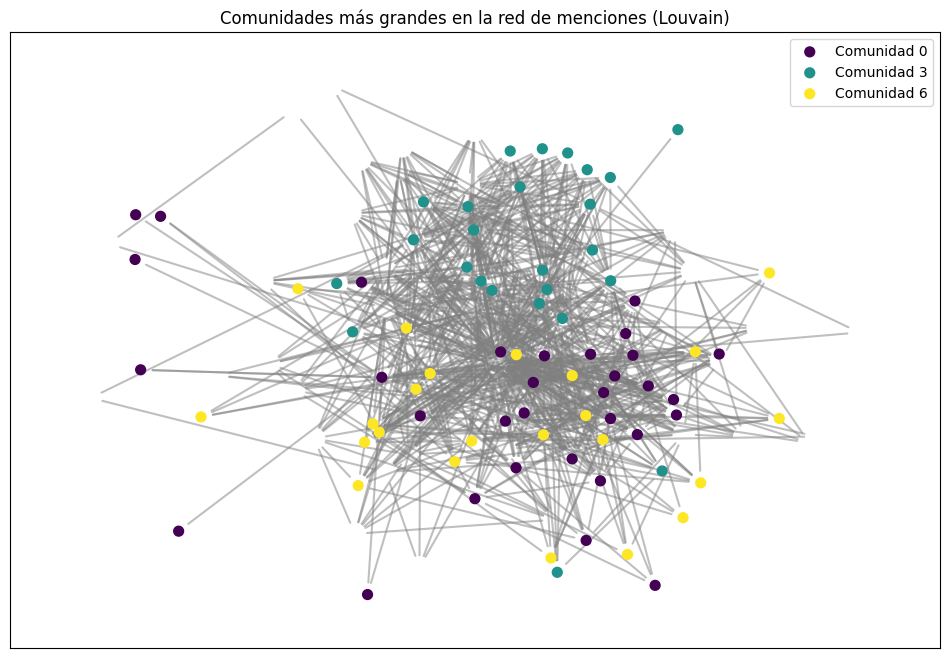

In [47]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# Obtener el tamaño de cada comunidad
community_sizes = {community: list(partition.values()).count(community) for community in set(partition.values())}
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:3]

# Asignar un color a cada comunidad
colors = cm.get_cmap('viridis', num_communities)

plt.figure(figsize=(12, 8))

# Ajustar el parámetro k para separar más los nodos
pos = nx.spring_layout(G_undirected, k=0.7, iterations=50)

# Dibujar cada comunidad con un color diferente
for community in largest_communities:
    nodes = [node for node in partition if partition[node] == community]
    nx.draw_networkx_nodes(G_undirected, pos, nodes, node_size=50, 
                           node_color=[colors(community)] * len(nodes), label=f'Comunidad {community}')
    
# Dibujar las aristas con un color gris claro y aumentar la separación
nx.draw_networkx_edges(G_undirected, pos, edge_color='gray', width=1.5, alpha=0.5)

# Opcional: eliminar etiquetas de los nodos si no son necesarias
# nx.draw_networkx_labels(G_undirected, pos)

plt.title("Comunidades más grandes en la red de menciones (Louvain)")
plt.legend()
plt.show()


In [48]:
# Caracterización de las comunidades
for community in largest_communities:
    nodes = [node for node in partition if partition[node] == community]
    subgraph = G_undirected.subgraph(nodes)
    
    # Tamaño de la comunidad
    size = len(nodes)
    density = nx.density(subgraph)
    
    # Número de interacciones (aristas) dentro de la comunidad
    num_edges = subgraph.number_of_edges()
    
    # Nodos más influyentes (grado más alto)
    top_nodes = sorted(subgraph.degree, key=lambda x: x[1], reverse=True)[:3]
    
    print(f"Comunidad {community}:")
    print(f"Tamaño: {size} nodos")
    print(f"Interacciones: {num_edges} aristas")
    print(f"Densidad: {density:.4f}")
    print(f"Nodos más influyentes: {top_nodes}")
    print("\n")


Comunidad 0:
Tamaño: 32 nodos
Interacciones: 125 aristas
Densidad: 0.2520
Nodos más influyentes: [('guatemalagob', 15), ('kroldegarcia', 15), ('fjimenezmingob', 13)]


Comunidad 3:
Tamaño: 25 nodos
Interacciones: 117 aristas
Densidad: 0.3900
Nodos más influyentes: [('corleone_62', 12), ('mundo9999', 12), ('aldanav52139161', 12)]


Comunidad 6:
Tamaño: 23 nodos
Interacciones: 57 aristas
Densidad: 0.2253
Nodos más influyentes: [('benitoc67601310', 10), ('pollosdb', 8), ('elquenews', 8)]


